## import libs

In [1]:
import ctypes

import numpy as np
import matplotlib.pyplot as plt

from picosdk.ps2000 import ps2000 as ps
from picosdk.functions import adc2mV, assert_pico2000_ok

In [2]:
from ctypes import byref, c_byte, c_int16, c_int32, sizeof
from time import sleep

from picosdk.ps2000 import ps2000
from picosdk.functions import assert_pico2000_ok, adc2mV
from picosdk.PicoDeviceEnums import picoEnum

## connect

In [3]:
# Create status ready for use
status = {}

# Open 2000 series PicoScope
# Returns handle to chandle for use in future API functions
status["openUnit"] = ps.ps2000_open_unit()
assert_pico2000_ok(status["openUnit"])

# Create chandle for use
chandle = ctypes.c_int16(status["openUnit"])

## setup

In [59]:
SAMPLES = 8_000
OVERSAMPLING = 1

wantedTimeInterval = 300

In [60]:
# Set up channel A
# handle
# channel
# enabled
# coupling type
# voltage range
# analogue offset = 0 V

voltRangeA = ps.PS2000_VOLTAGE_RANGE['PS2000_2V']
status["setChA"] = ps.ps2000_set_channel(
        chandle,
        picoEnum.PICO_CHANNEL['PICO_CHANNEL_A'],
        True,
        picoEnum.PICO_COUPLING['PICO_DC'],
        voltRangeA,
    )

assert_pico2000_ok(status["setChA"])

In [61]:
# Set up channel B
# handle
# channel
# enabled
# coupling type
# voltage range
# analogue offset = 0 V

voltRangeB = ps.PS2000_VOLTAGE_RANGE['PS2000_5V']
status["setChB"] = ps.ps2000_set_channel(
        chandle,
        picoEnum.PICO_CHANNEL['PICO_CHANNEL_B'],
        True,
        picoEnum.PICO_COUPLING['PICO_DC'],
        voltRangeB,
    )

assert_pico2000_ok(status["setChB"])

In [62]:
# Set up single trigger
# handle
# source
# threshold in ADC counts (max adc count 32767)  # evaluated values in bufferB
# direction
# delay = 0 s
# auto Trigger = 1000 ms
status["trigger"] = ps.ps2000_set_trigger(chandle, 
                                          picoEnum.PICO_CHANNEL['PICO_CHANNEL_B'], 
                                          10000, 
                                          picoEnum.PICO_THRESHOLD_DIRECTION['PICO_RISING'], 
                                          0, 
                                          5000)
assert_pico2000_ok(status["trigger"])

## timebase information

In [63]:
def get_timebase(chandle, wantedTimeInterval):
    currentTimebase = 1

    oldTimeInterval = None
    timeInterval = c_int32(0)
    timeUnits = c_int16()
    maxSamples = c_int32()

    # handle
    # timebase
    # no_of_samples = maxSamples
    # pointer to time_interval = ctypes.byref(timeInterval)
    # pointer to time_units = ctypes.byref(timeUnits)
    # oversample = 1 = oversample
    # pointer to max_samples = ctypes.byref(maxSamplesReturn)
    while ps.ps2000_get_timebase(
                chandle,
                currentTimebase,
                2000,
                byref(timeInterval),
                byref(timeUnits),
                1,
                byref(maxSamples)) \
            == 0  \
                or timeInterval.value < wantedTimeInterval:

        currentTimebase += 1
        oldTimeInterval = timeInterval.value

        if currentTimebase.bit_length() > sizeof(c_int16) * 8:
            raise Exception('No appropriate timebase was identifiable')

    return currentTimebase - 1, oldTimeInterval, timeInterval

get_timebase(chandle, wantedTimeInterval)

(5, 160, c_int(320))

## capture

In [64]:
timebase_a, interval, timeInterval = get_timebase(chandle, wantedTimeInterval)

collection_time = c_int32()

# Run block capture
# handle
# no_of_samples
# timebase
# oversample
# pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
res = ps.ps2000_run_block(
    chandle,
    SAMPLES,
    timebase_a,
    OVERSAMPLING,
    byref(collection_time)
)
assert_pico2000_ok(res)

while ps.ps2000_ready(chandle) == 0:
    sleep(0.1)

times = (c_int32 * SAMPLES)()

bufferA = (c_int16 * SAMPLES)()
bufferB = (c_int16 * SAMPLES)()

overflow = c_byte(0)

status["timesValues"] = ps.ps2000_get_times_and_values(
    chandle,
    byref(times),
    byref(bufferA),
    byref(bufferB),
    None,
    None,
    byref(overflow),
    2,
    SAMPLES,
)
assert_pico2000_ok(status["timesValues"])

channel_a_overflow = (overflow.value & 0b0000_0001) != 0

## visualize

In [65]:
# find maximum ADC count value
maxADC = ctypes.c_int16(32767)

# convert ADC counts data to mV
adc2mVChA =  adc2mV(bufferA, voltRangeA, maxADC)
adc2mVChB =  adc2mV(bufferB, voltRangeB, maxADC)

# Create time data
time = np.linspace(0, (SAMPLES) * timeInterval.value, SAMPLES)/1_000_000

#### channel A

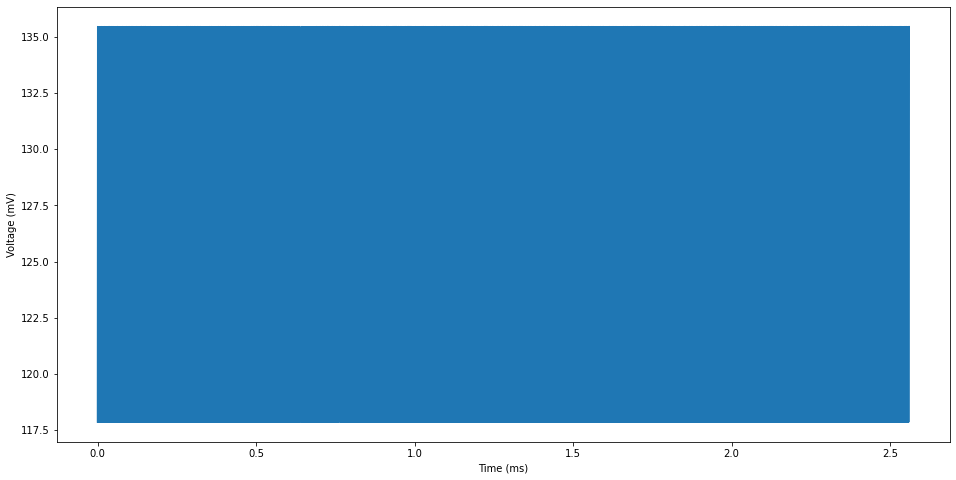

In [66]:
# plot data from channel A and B
plt.figure(figsize=(16, 8))
plt.plot(time, adc2mVChA[:])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
if channel_a_overflow:
    plt.text(0.01, 0.01, 'Overflow present', color='red')
plt.show()

#### channel B

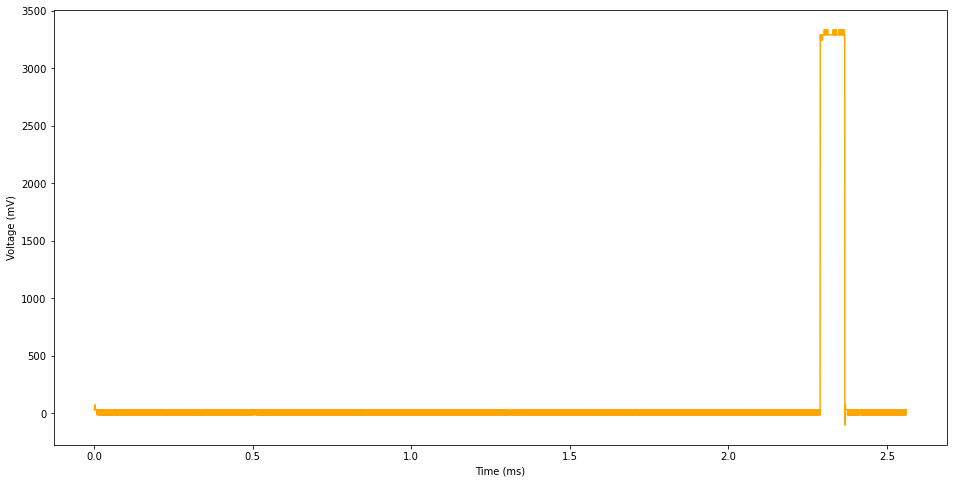

In [67]:
# plot data from channel A and B
plt.figure(figsize=(16, 8))
plt.plot(time, adc2mVChB, color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
if channel_a_overflow:
    plt.text(0.01, 0.01, 'Overflow present', color='red')
plt.show()

In [68]:
len(adc2mVChB)

8000

## capture multiple

In [69]:
# define function
timebase_a, interval, timeInterval = get_timebase(chandle, wantedTimeInterval)

def captureBlock(timebase_a, interval, timeInterval):

    collection_time = c_int32()

    # Run block capture
    # handle
    # no_of_samples
    # timebase
    # oversample
    # pointer to time_indisposed_ms = ctypes.byref(timeIndisposedms)
    res = ps.ps2000_run_block(
        chandle,
        SAMPLES,
        timebase_a,
        OVERSAMPLING,
        byref(collection_time)
    )
    assert_pico2000_ok(res)

    while ps.ps2000_ready(chandle) == 0:
        sleep(0.1)

    times = (c_int32 * SAMPLES)()

    bufferA = (c_int16 * SAMPLES)()
    bufferB = (c_int16 * SAMPLES)()

    overflow = c_byte(0)

    res = ps.ps2000_get_times_and_values(
        chandle,
        byref(times),
        byref(bufferA),
        byref(bufferB),
        None,
        None,
        byref(overflow),
        2,
        SAMPLES,
    )
    assert_pico2000_ok(res)

    channel_a_overflow = (overflow.value & 0b0000_0001) != 0
    
    return bufferA, bufferB, channel_a_overflow

captureBlock(timebase_a, interval, timeInterval)

(<__main__.c_short_Array_8000 at 0x7f77fcfb5a40>,
 False)

In [71]:
# run multiple and average the trace to remove noise

avgTrace = None

loops = 100
for i in range(loops):
    bufferA, bufferB, channel_a_overflow = captureBlock(timebase_a, interval, timeInterval)
    
    if bufferB[0]>10_000: continue
        
    trace = [bufferA[i] for i in range(len(bufferA)) if bufferB[i]>10_000]  # 10,000 adc count as threshold
    
    if avgTrace == None:
        avgTrace = trace
    else:
        lastElt = min(len(avgTrace), len(trace))
        avgTrace = [avgTrace[i] + trace[i] for i in range(lastElt)]

avgTrace = [elt/loops for elt in avgTrace]
print(avgTrace[:10])

[20609.8, 20615.56, 20673.16, 20693.32, 20641.48, 20629.96, 20641.48, 20641.48, 20661.64, 20627.08]


In [72]:
# find maximum ADC count value
maxADC = ctypes.c_int16(32767)

# convert ADC counts data to mV
adc2mVtrace =  adc2mV(avgTrace, voltRangeA, maxADC)

# Create time data
time = np.linspace(0, (len(adc2mVtrace)) * timeInterval.value, len(adc2mVtrace))/1_000_000

In [73]:
len(time)

243

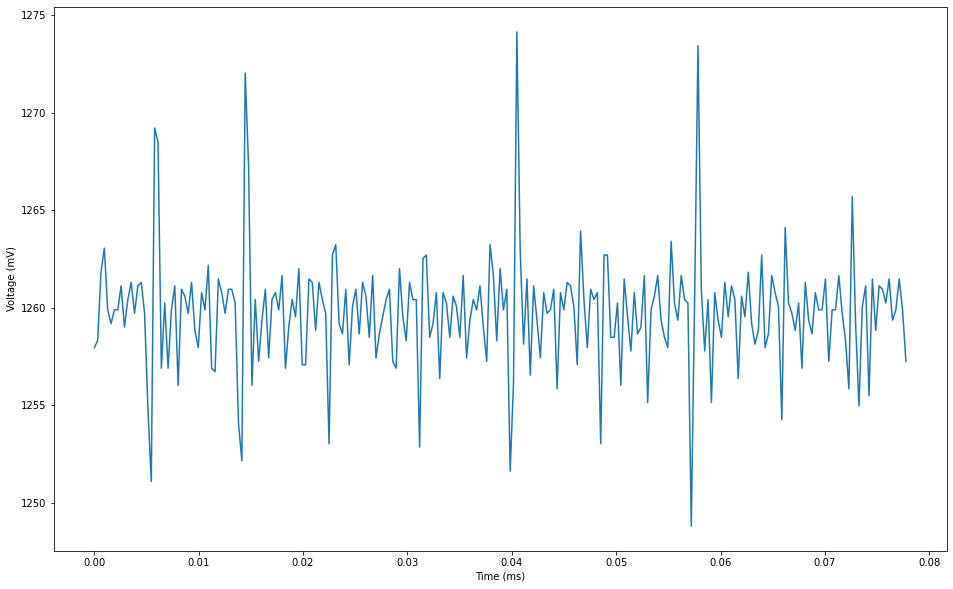

In [74]:
# plot data
plt.figure(figsize=(16, 10))
plt.plot(time, adc2mVtrace[:])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.show()

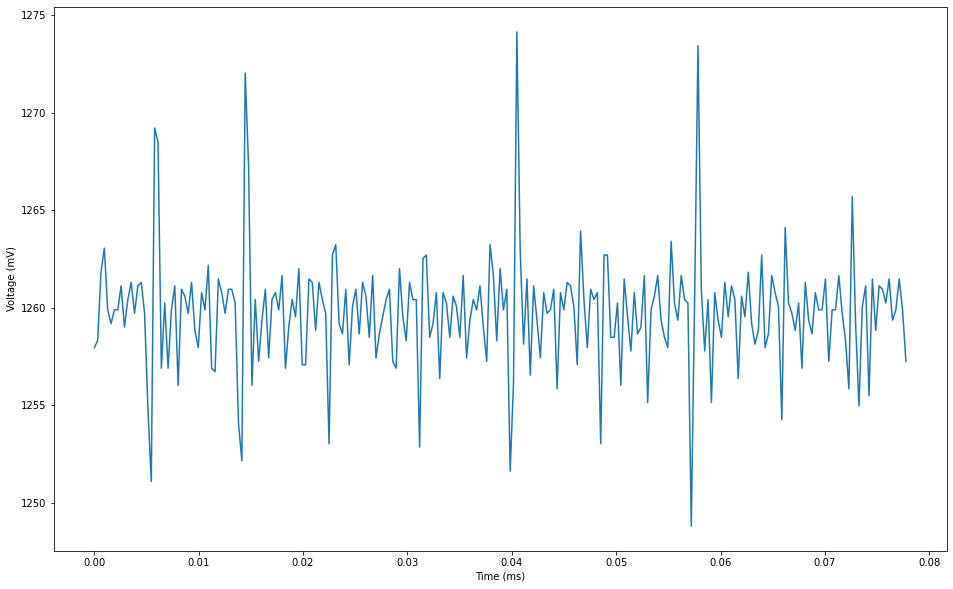

In [75]:
# plot data
plt.figure(figsize=(16, 10))
plt.plot(time, adc2mVtrace[:])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.show()

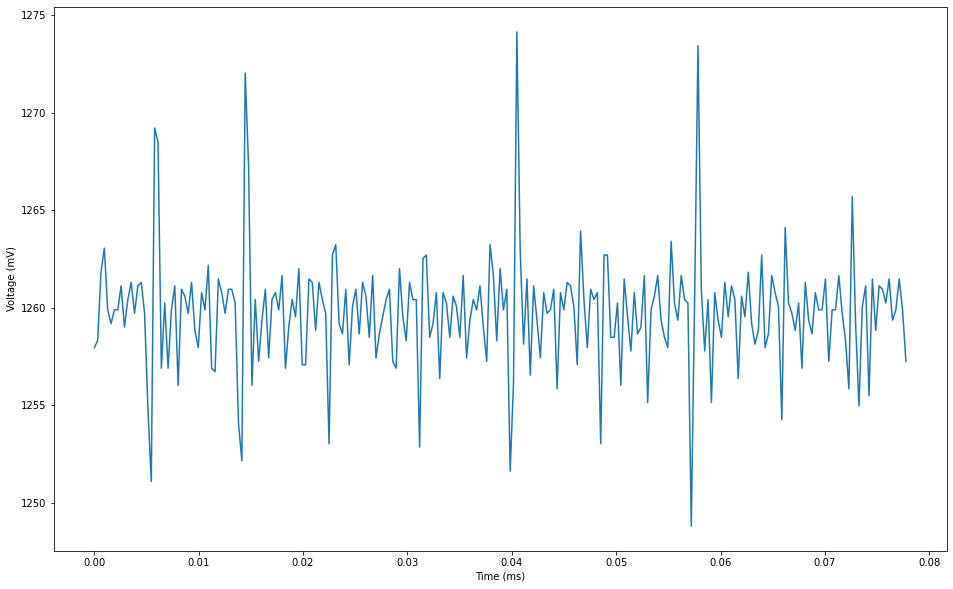

In [78]:
plt.figure(figsize=(16, 10))
plt.plot(time, adc2mVtrace[:])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

#plt.savefig('spa.png')

## disconnect and print status

In [ ]:
wait
# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000_stop(chandle)
assert_pico2000_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps2000_close_unit(chandle)
assert_pico2000_ok(status["close"])

# display status returns
print(status)